# Band Structure in the Bose-Hubbard Model

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('notebook')
from colors import ggplot
%matplotlib inline
import scipy.linalg as linalg
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy import interpolate

Start from the non-interacting Hamiltonian:

\begin{equation}
H = \frac{p^2}{2m} + U_0 \sin^2 k x
\end{equation}

where $k = \pi/a_0$ with $a_0$ the lattice spacing.  Exploiting Bloch's theorem, we find the eigenvalue equation:

\begin{equation}
\sum_{\ell'} H_{\ell,\ell'} c_{\ell'}^{(n,q)} = E_q^{(n)} c_{\ell}^{(n,q)}
\end{equation}

where

\begin{equation}
H_{\ell',\ell} = \left[E_R\left(2\ell+\frac{q}{k}\right)^2 + \frac{V_0}{2}\right]\delta_{\ell,\ell'} - \frac{V_0}{4} \left(\delta_{\ell,\ell'+1} + \delta_{\ell,\ell'-1} \right)
\end{equation}

with the natural scale being set by the recoil energy:

\begin{equation}
E_R = \frac{\hbar^2 k^2}{2m} .
\end{equation}


In [67]:
def build_Hamiltonian(V0,q,M):
    '''The NxN tridiagonal matrix.
    
       V0 is in units of E_R.
       q is in units of k=\pi/a_0'''
    
    d = np.array([(2.0*j+q)**2 + 0.5*V0 for j in range(-int(M/2),int(M/2))])
    od = -0.25*V0*np.ones(len(d)-1)
    H = diags([d,od,od],[0, -1, 1]).toarray()
    return H

In [68]:
def get_spectrum(V0,N,M=50,k=3):
    q = np.arange(-1.0,1.0,2.0/N)
    Eq = np.zeros([N,k])
    C = np.zeros([M,N])
    for i,cq in enumerate(q):
        H = build_Hamiltonian(V0,cq,M) 
        e,v = linalg.eigh(H)
        idx = e.argsort()
        Eq[i,:] = e[idx][:k]
        C[:,i] = v[:,idx][:,0]
    return q,Eq,C

## Plot the band structure

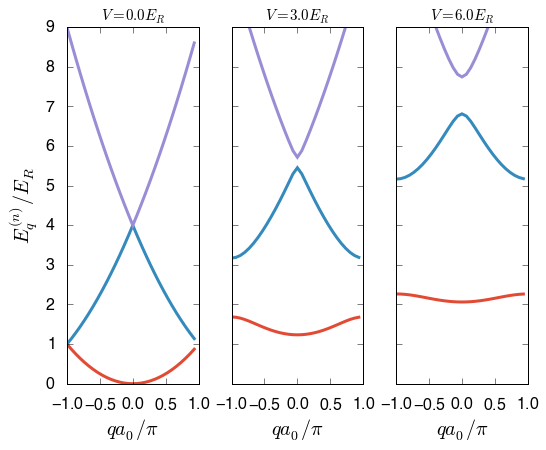

In [69]:
f, axes = plt.subplots(ncols=3, nrows=1, figsize=(8,6), sharex=False, sharey=True, squeeze=True)

V0 = [0,3.0,6.0]
for i,ax in enumerate(axes):
    q,Eq,C = get_spectrum(V0[i],30)
    ax.plot(q,Eq)
    if i==0:
        ax.set_ylabel(r'$E^{(n)}_q/E_R$')

    ax.set_xlabel(r'$qa_0/\pi$')
    ax.text(0.5,1.02,r'$V= %3.1fE_R$' % V0[i],fontsize=15,transform=ax.transAxes, ha='center')

plt.subplots_adjust(wspace=0.25)
plt.ylim([0,9]);
plt.savefig('bands_structure.png')

## Define the Wannier functions

For the lowest Bloch band:

\begin{equation}
w(x-x_j) = \frac{1}{\sqrt{N a_0}} \sum_q  \mathrm{e}^{i q x_j} \Phi^{(0)}_q(x)
\end{equation}

where 

\begin{equation}
\Phi_q^{(0)}(x)= \mathrm{e}^{i q x} \sum_{\ell} C_{\ell}^{(0,q)} \mathrm{e}^{i2k\ell x} .
\end{equation}

In [8]:
def Wannier(x,j,C):
    '''Compute the dimensionless Wannier function at point x/a_0.'''
    M,N = C.shape
    q = np.pi*np.arange(-1.0,1.0,2.0/N)
    l = 2.0*np.pi*np.arange(-int(M/2),int(M/2),1)
    
    Q,L = np.meshgrid(q,l)
    
    w = np.sum(C*np.exp(1j*L*x)*np.exp(1j*Q*x)*np.exp(-1j*Q*j))
    return w/N

def D2Wannier(x,j,C):
    '''The second derivative of the dimensionless Wannier function at point x/a_0.'''
    M,N = C.shape
    q = np.pi*np.arange(-1.0,1.0,2.0/N)
    l = 2.0*np.pi*np.arange(-int(M/2),int(M/2),1)
    
    Q,L = np.meshgrid(q,l)
    
    w = np.sum((Q+L)**2*C*np.exp(1j*L*x)*np.exp(1j*Q*x)*np.exp(-1j*Q*j))
    return w/N

def normKernel(x,j,k,C):
    w1 = np.conj(Wannier(x,j,C))
    w2 = Wannier(x,k,C)
    return w1*w2

### Plot some Wannier functions

First we check the normalization

In [70]:
cV = 1.0
cN = 12
q,Eq,C = get_spectrum(cV,cN,k=1)

In [35]:
quad(normKernel,-0.5*12,0.5*12,args=(0,1,C))

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/integrate/quadpack.py:376: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


(3.103596481375537e-16, 5.444190118842885e-12)

In [71]:
x = np.linspace(-5,5,500)
w0 = np.array([Wannier(cx,0,C) for cx in x])
w1 = np.array([Wannier(cx,1,C) for cx in x])
w2 = np.array([Wannier(cx,-1,C) for cx in x])
#D2w = np.array([D2Wannier(cx,0,C) for cx in x])

### Testing for $V/E_R = 10$

In [37]:
cV = 10
cN = 12
q,Eq,C1 = get_spectrum(cV,cN,k=1)
w0 = np.array([Wannier(cx,0,C1) for cx in x])

In [38]:
xt = [-1.524, -1.339, -0.930, -0.576, -0.309, -0.170, -0.082, -0.006, 0.103, 0.196, 0.390, 0.845, 1.527]
wt = [-0.007, -0.007, -0.007, 0.068, 0.533, 1.212, 1.602, 1.711, 1.409, 0.955, 0.254, 0.010, -1.688e-4]

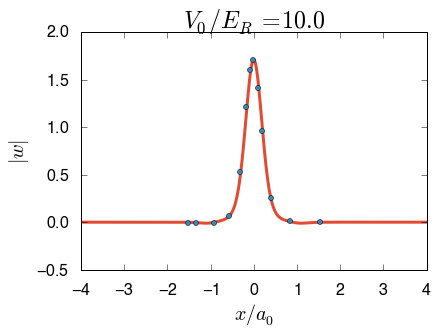

In [40]:
plt.plot(x,np.real(w0))
plt.plot(xt,wt,'o',markersize=5)
#plt.plot(x,np.abs(w1))
#plt.plot(x,np.abs(w2))
#plt.plot(x,np.real(D2w))
plt.xlabel(r'$x/a_0$')
plt.ylabel(r'$|w|$')
plt.title(r'$V_0/E_R = 10.0$')
plt.xlim(-4,4);

### Plotting the Wannier Functions

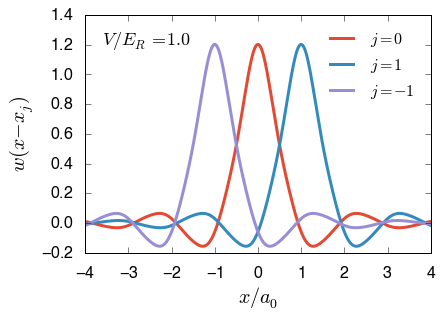

In [72]:
plt.plot(x,np.real(w0),label='$j=0$')
plt.plot(x,np.real(w1),label='$j=1$')
plt.plot(x,np.real(w2),label='$j=-1$')
#plt.plot(xt,wt,'o',markersize=5)
#plt.plot(x,np.abs(w1))
#plt.plot(x,np.abs(w2))
#plt.plot(x,np.real(D2w))
plt.xlabel(r'$x/a_0$')
plt.ylabel(r'$w(x-x_j)$')
plt.text(-3.6,1.2,r'$V/E_R = 1.0$', fontsize=18)
plt.xlim(-4,4);
plt.legend()
plt.savefig('wannier.png')

## Interpolate the Wannier functions

In [45]:
def interp_Wannier(j,N,C):
    x = np.linspace(-0.5*N-0.1, 0.5*N+0.1,10000)
    w = np.array([Wannier(cx,j,C) for cx in x])
    return interpolate.interp1d(x, w)

In [46]:
cN = 20
cV = 10
q,Eq,C = get_spectrum(cV,cN,k=1)
%timeit w_interp = interp_Wannier(0,cN,C)

1 loops, best of 3: 1.25 s per loop


## Compute the hopping and interaction parameters

\begin{align}
t &= -\int_{-L/2}^{L/2} dx\ w^\ast(x) \left( -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V_0 \sin^2 kx \right) w(x-a_0) \\
\frac{t}{E_R}&= \int_{-N/2}^{N/2} d\overline{x}\ \left[ \frac{1}{\pi^2}\overline{w}^\ast(\overline{x}) \overline{w}''(\overline{x}-1) + \frac{V_0}{E_R} \sin^2 (\pi \overline{x}) \overline{w}^\ast(\overline{x}) \overline{w}(\overline{x}-1) \right] 
\end{align}

In [142]:
def tKernel(x,V0,C):
    w0 = np.conj(Wannier(x,0,C))
    w1 = Wannier(x,1,C)
    w2 = D2Wannier(x,1,C)
    return -np.real(w0*w2/(np.pi*np.pi) + V0*w0*w1*(np.sin(np.pi*x))**2)

def get_t(V0,N,C):
    return quad(tKernel,-0.5*N,0.5*N,args=(V0,C))[0]

def approx_t(V0):
    return (4.0/np.sqrt(np.pi))*(V0**0.75)*np.exp(-2.0*np.sqrt(V0))

def UKerneldelta(x,C):
    w = Wannier(x,0,C)
    return np.real((w*np.conj(w)))**2

def UKernalGaussian(x,y,a,w_interp):
    wx = w_interp(x)
    wy = w_interp(y)
    V = np.exp(-(x-y)**2/(2.0*a**2))
    return np.real(wx*np.conj(wx)*wy*np.conj(wy)*V)

def UKernalGaussianW(x,y,a,C):
    wx = Wannier(x,0,C)
    wy = Wannier(y,0,C)
    V = np.exp(-(x-y)**2/(2.0*a**2))
    return np.real(wx*np.conj(wx)*wy*np.conj(wy)*V)
    
def get_Udelta(a,N,C):
    '''a = |a_{1D}/a_0|'''
    return 4.0/(a*np.pi**2)*quad(UKerneldelta,-0.5*N,0.5*N,args=(C))[0]

def get_U(a,N,w_interp):
    low = lambda x: -0.5*N
    high = lambda x: 0.5*N
    prefact = 4.0/(np.sqrt(2.0*np.pi)*np.pi**2*a**2)
    return prefact*dblquad(UKernalGaussian,-0.5*N,0.5*N,low,high,args=(a,w_interp))[0]

def get_UW(a,N,C):
    low = lambda x: -0.5*N
    high = lambda x: 0.5*N
    prefact = 4.0/(np.sqrt(2.0*np.pi)*np.pi**2*a**2)
    return prefact*dblquad(UKernalGaussianW,-0.5*N,0.5*N,low,high,args=(a,C))[0]

def UKernalGaussianSimps(x,a,w_interp,y):
    wx = w_interp(x)
    wy = w_interp(y)
    V = np.exp(-(x-y)**2/(2.0*a**2))
    return np.real(simps(wx*np.conj(wx)*wy*np.conj(wy)*V, x=y))

def get_US(a,N,w_interp):
    x = np.linspace(-0.5*N,0.5*N,100)
    prefact = 4.0/(np.sqrt(2.0*np.pi)*np.pi**2*a**2)
    inner = np.array([UKernalGaussianSimps(cx,a,w_interp,x) for cx in x])
    return prefact*simps(inner,x=x)

### Test for a particular value of $V$ and $a$

In [143]:
cN = 12
cV = 0.1
ca = 0.3
q,Eq,C = get_spectrum(cV,cN,k=1)
w_interp = interp_Wannier(0,cN,C)
t0 = get_t(cV,cN,C)
U0 = get_Udelta(ca,cN,C)

In [144]:
U0/t0

4.995009903101005

## Get $t$ and $U$ a function of $V_0/E_R$

In [204]:
cN = 12
V0 = np.linspace(0,20,100)
t = np.zeros_like(V0)
a = [0.8, 1.0, 2.0, 4.0]
U = np.zeros([len(t),len(a)])

for i,cV in enumerate(V0):
    q,Eq,C = get_spectrum(cV,cN,k=1)
    t[i] = get_t(cV,cN,C)
    for j,ca in enumerate(a):
        U[i,j] = get_Udelta(ca,cN,C)
    if i%5==0:
        print(cV)

0.0
1.0101010101
2.0202020202
3.0303030303
4.0404040404
5.05050505051
6.06060606061
7.07070707071
8.08080808081
9.09090909091
10.101010101
11.1111111111
12.1212121212
13.1313131313
14.1414141414
15.1515151515
16.1616161616
17.1717171717
18.1818181818
19.1919191919


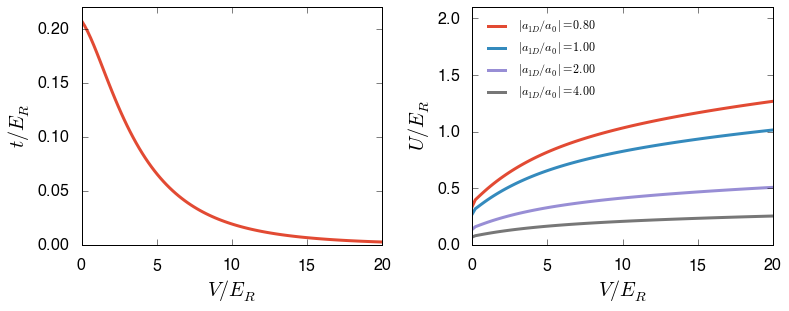

In [206]:
f, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4), sharex=True, sharey=False, squeeze=True)

axes[0].plot(V0,t)
axes[0].set_xlabel(r'$V/E_R$')
axes[0].set_ylabel(r'$t/E_R$')
axes[0].set_ylim(0,0.22)

for j,ca in enumerate(a):
    axes[1].plot(V0,U[:,j], label=r'$|a_{1D}/a_0| = %4.2f$' % ca)

axes[1].set_xlabel(r'$V/E_R$')
axes[1].set_ylabel(r'$U/E_R$')
axes[1].legend(loc='upper left', fontsize=12)
axes[1].set_ylim(0,2.1)

plt.subplots_adjust(wspace=0.30)
plt.xlim(0,20);
plt.savefig('t_U_vs_VoER.png')

## Now plot the ratio $U/t$

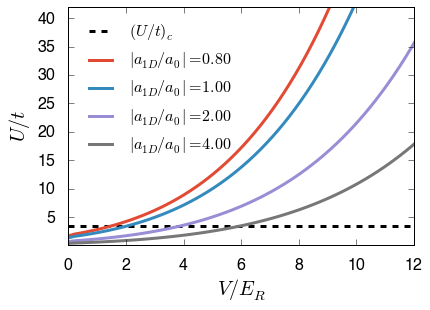

In [207]:
plt.axhline(y=1.0/0.297, linestyle='--', label=r'$(U/t)_c$')

for j,ca in enumerate(a):
    plt.plot(V0,U[:,j]/t, label=r'$|a_{1D}/a_0| = %4.2f$' % ca)

plt.xlabel(r'$V/E_R$')
plt.ylabel(r'$U/t$')
plt.legend(loc='upper left')
plt.ylim(0.1,42);
plt.xlim(0,12);
plt.savefig('Uot.png')

## Find the critical line

In [194]:
a_s = np.linspace(0.4,16,100)
Uotc = 1.0/0.297

In [196]:
Vc = []
cN = 12
startV = 0.0
for ca in a_s:
    for cVc in np.linspace(startV,12,100):
        q,Eq,C = get_spectrum(cVc,cN,k=1)
        ct = get_t(cVc,cN,C)
        cU = get_Udelta(ca,cN,C)
        #print(cVc,cU/ct)
        if cU/ct > Uotc:
            Vc.append(cVc)
            startV = cVc
            print(ca,cVc)
            break

0.4 0.121212121212
0.557575757576 0.721150902969
0.715151515152 1.29078974625
0.872727272727 1.72348511004
1.0303030303 2.13869783287
1.18787878788 2.53713428407
1.34545454545 2.82388779061
1.50303030303 3.10195179695
1.66060606061 3.37158962129
1.81818181818 3.63305660246
1.97575757576 3.88660034178
2.13333333333 4.05050740558
2.29090909091 4.29140112057
2.44848484848 4.44713039086
2.60606060606 4.6760052275
2.76363636364 4.82396471785
2.92121212121 4.96893512759
3.07878787879 5.18199769948
3.23636363636 5.3197351197
3.39393939394 5.45468996576
3.55151515152 5.5869184513
3.70909090909 5.71647565431
3.86666666667 5.84341554008
4.02424242424 5.96779098371
4.18181818182 6.08965379212
4.33939393939 6.20905472562
4.49696969697 6.32604351904
4.65454545455 6.44066890249
4.81212121212 6.55297862163
4.9696969697 6.66301945756
5.12727272727 6.7708372463
5.28484848485 6.87647689789
5.44242424242 6.9799824151
5.6 7.08139691176
5.75757575758 7.13107977124
5.91515151515 7.22944179606
6.07272727273 

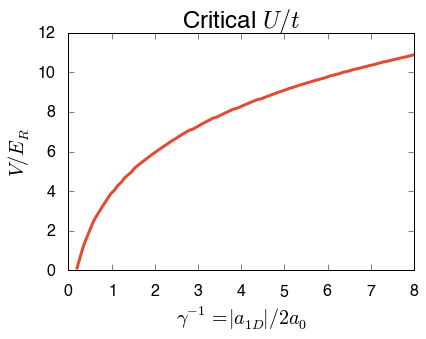

In [208]:
plt.plot(0.5*a_s,Vc)
plt.ylabel(r'$V/E_R$')
plt.xlabel(r'$\gamma^{-1} = |a_{1D}|/2a_0$')
plt.title('Critical $U/t$')
plt.savefig('critical_line.png')

In [209]:
1/0.297

3.367003367003367

## Experimental Parameters

In [226]:
from scipy.constants import hbar

m_Rb = 1.44467E-27 # kg
omega_z = 2.0*np.pi*800 # Hz
a3D = 5.3E-9 #m
CO = 1.4603 
a0 = 680E-9 #m

In [234]:
a_z = (2.0*hbar/(m_Rb*omega_z))**(0.5)
a_perp = np.sqrt(a_z*a0)
#a_perp = 0.5*(a_z + a0)
print('a_z = ',a_z*1E9,'nm')
print('a_perp = ',a_perp*1E9,'nm')

a_z =  5389.317930010744 nm
a_perp =  1914.3500705 nm


In [235]:
a1D = a_perp**2/(2.0*a3D)*(1.0-CO*a3D/a_perp)
print('a_1D = ',a1D*1E9,'nm')

a_1D =  344332.066768 nm


In [236]:
print('a1D/a0 = ', a1D/a0)

a1D/a0 =  506.370686424
